In [750]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr, kendalltau, spearmanr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

Carrega a base de média diária de voos

In [751]:
international_flights_avg = pd.read_csv('jan-media_voos.csv')
international_flights_avg = international_flights_avg[['org', 'dest', 'valor_norm']]
international_flights_avg = international_flights_avg.rename(columns={'org': 'source', 'dest': 'target', 'valor_norm':'value'})

In [752]:
international_flights_avg.head()

,source,target,value
0,Algeria,Austria,1.000000
1,Algeria,Belgium,1.275510
2,Algeria,Canada,1.000000
3,Algeria,France,12.272727
4,Algeria,Germany,1.560345


Constrói o grafo com a probabilidade de voos entre países

In [753]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()

transition_matrix = transition_matrix.set_index('source').join(country_international_flights, lsuffix='_daily_flights', rsuffix='_source_sum_flights')

transition_matrix['prob'] = (transition_matrix['value_daily_flights']/transition_matrix['value_source_sum_flights'])
transition_matrix = transition_matrix.drop(columns=['value_source_sum_flights', 'value_daily_flights']).reset_index()

In [754]:
transition_matrix.head()

,source,target,prob
0,Algeria,Austria,0.027296
1,Algeria,Belgium,0.034816
2,Algeria,Canada,0.027296
3,Algeria,France,0.334996
4,Algeria,Germany,0.042591


In [755]:
transition_matrix.groupby('source')[['prob']].sum()

,prob
source,
Algeria,1.0
Argentina,1.0
Armenia,1.0
Australia,1.0
Austria,1.0
Bahrain,1.0
Bangladesh,1.0
Barbados,1.0
Belarus,1.0


Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [756]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])



In [757]:
countries = transition_matrix['source'].unique()

def get_cases(day=77):
    cases = total_cases.xs(day, level=1).reindex(countries).fillna(0)

    cases = cases.rename(columns={'Total': 'n_cases'}) 
    return cases

daily_cases = get_cases()

In [758]:
#TODO: os nomes das df de voos e  casos parecem estar muito diferentes. eh preciso normaliza-los... veja que tem muito valor nulo no votor abaixo 

state_df_start = total_cases.xs(0, level=1).reindex(transition_matrix['source'].unique())
state_df_start = state_df_start.fillna(0)

state_df_start

,Total
Name,
Algeria,0.0
Argentina,0.0
Armenia,0.0
Australia,0.0
Austria,0.0
Bahrain,0.0
Bangladesh,0.0
Barbados,0.0
Belarus,0.0


Faz o random walk

In [759]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

In [760]:
transition_matrix = transition_matrix.set_index(['source', 'target'])

In [761]:
def transition_matrix_loss(loss_df):    
    df_joined = transition_matrix.join(loss_df, how='left')

    df_joined['prob'] = df_joined['prob']*df_joined['pct_loss']

    df_joined = df_joined.reset_index()

    df_joined = pd.crosstab(df_joined['target'], df_joined['source'], df_joined['prob'], aggfunc=sum)
    df_joined = df_joined.fillna(0)

    return df_joined

In [762]:
week_loss_df = pd.read_csv('data/week_pct_loss.csv').drop(columns=['Unnamed: 0']).rename(columns={'org': 'source', 'dest':'target'})

In [763]:
def model_spread2(r, p, use_loss=False, day=77):
    state_df = state_df_start
    
    for i in range(1, (day+1)):
        week = math.floor(i/7)
        if(week<5):
            state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
        else:
            if use_loss:
                week_loss = week_loss_df.set_index(['week_value']).loc[week].reset_index().set_index(['source', 'target']).drop(columns=['week_value'])
                transition_matrix_week =transition_matrix_loss(week_loss)
                state_df = state_df*r + (transition_matrix_week.dot(state_df)*p)
            else:
                state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
            
            
    return state_df

In [764]:
def model_optimize(day=77, use_loss=False):
    cases = get_cases(day)
    # function we would like to fit
    func=lambda tpl : model_spread2(tpl[0], tpl[1], use_loss, day).T.values[0]
    # ErrorFunc is the diference between the func and the y "experimental" data
    ErrorFunc=lambda tpl,cases: func(tpl)-cases # np.sqrt(np.abs(func(tpl)-cases))
    #tplInitial contains the "first guess" of the parameters 
    tplInitial1=(1.001,0.0000001)
    # leastsq finds the set of parameters in the tuple tpl that minimizes
    # ErrorFunc=yfit-yExperimental
    tplFinal1,success=leastsq(ErrorFunc,tplInitial1[:],args=(cases['n_cases'].values))
    print(" params ",tplFinal1)


    return pd.DataFrame({'CasesPredicted':func(tplFinal1)}, index=transition_matrix_crosstab.columns)
    

In [765]:
df_model_corr = pd.DataFrame({'Day':[], 'NoLoss':[], 'WithLoss':[]}).set_index('Day')

In [766]:

gap = 4 #para agilizar nos testes, usem valores maiores que 1

for d in range(30, 77, gap):
    state_df= model_optimize(day=d, use_loss=False)
    state_df_loss= model_optimize(day=d, use_loss=True)
    cases = get_cases(d)
    
    pearson_nl = pearsonr(state_df['CasesPredicted'].values, cases['n_cases'].values)
    spearman_nl = spearmanr(state_df['CasesPredicted'].values, cases['n_cases'].values)
    pearson_l = pearsonr(state_df_loss['CasesPredicted'].values, cases['n_cases'].values)
    spearman_l = spearmanr(state_df_loss['CasesPredicted'].values, cases['n_cases'].values)
    df_model_corr.loc[d, 'NoLoss'] = spearman_nl[0]
    df_model_corr.loc[d, 'WithLoss'] = spearman_l[0]
    print('==========', d, ' days ============')
    print('No loss ->', 'pearsonr: ', pearson_nl,
        '\n           ', 'spearmanr: ', spearman_nl)
    print('With loss ->', 'pearsonr: ', pearson_l,
        '\n           ', 'spearmanr: ', spearman_l)



 params  [1.20753945e+00 4.99388698e-04]
 params  [1.20753945e+00 4.99388698e-04]
========== 30  days ============
No loss -> pearsonr:  (0.999997727287323, 4.647798179402428e-186) 
            spearmanr:  SpearmanrResult(correlation=0.5959938077675054, pvalue=4.170385576845681e-08)
With loss -> pearsonr:  (0.999997727287323, 4.647798179402428e-186) 
            spearmanr:  SpearmanrResult(correlation=0.5959938077675054, pvalue=4.170385576845681e-08)
 params  [1.20915949e+00 3.57846355e-04]
 params  [1.20915949e+00 3.57846355e-04]
========== 34  days ============
No loss -> pearsonr:  (0.9999988294199119, 5.324853722779209e-196) 
            spearmanr:  SpearmanrResult(correlation=0.662236139890438, pvalue=3.187628226917105e-10)
With loss -> pearsonr:  (0.9999988294199119, 5.324853722779209e-196) 
            spearmanr:  SpearmanrResult(correlation=0.662236139890438, pvalue=3.187628226917105e-10)
 params  [1.20393299e+00 2.46355822e-04]
 params  [1.20393299e+00 2.69376036e-04]
========

In [767]:
df_model_corr

,NoLoss,WithLoss
Day,,
30.0,0.595994,0.595994
34.0,0.662236,0.662236
38.0,0.669705,0.661700
42.0,0.670881,0.663881
46.0,0.670435,0.659526
50.0,0.670190,0.658297
54.0,0.675303,0.674476
58.0,0.577903,0.594985
62.0,0.537987,0.540889


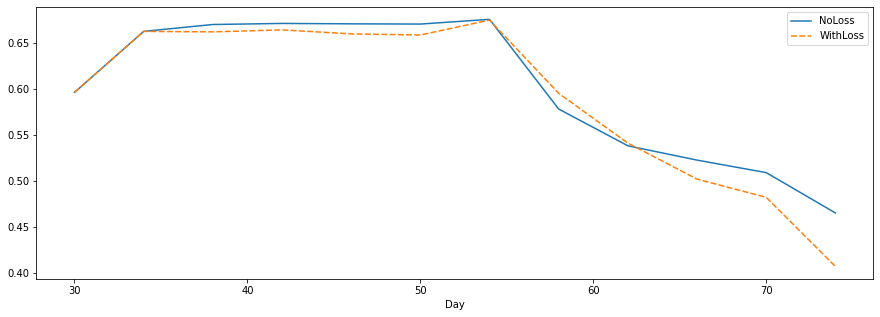

In [784]:
plt.figure(figsize=(15,5))

sns.lineplot(data=df_model_corr)

Cria o dataframe a ser utilizado e roda o gridsearch

In [768]:
#state_df_final = model_spread2(r_min_dist, p)

print(state_df_final.sum())

state_df_final.sort_values('CasesPredicted', ascending=False)

CasesPredicted    155907.265323
dtype: float64


,CasesPredicted
source,
China,80925.202753
Thailand,4645.495502
South Korea,4316.150787
Taiwan,3851.072985
United States,3796.387147
Malaysia,3633.662428
Japan,3536.791049
Singapore,3414.492489
Germany,2730.626399


In [769]:
print(daily_cases.sum())

daily_cases.sort_values('n_cases', ascending=False)

n_cases    166950.0
dtype: float64


,n_cases
Name,
China,81063.0
Italy,27980.0
Spain,13994.0
South Korea,8320.0
France,6633.0
Germany,6012.0
United States,4661.0
Switzerland,2200.0
United Kingdom,1543.0


In [770]:
#pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])
pearsonr(state_df_final['CasesPredicted'].values, daily_cases['n_cases'].values)

(0.9293088874945158, 1.4496666889649186e-31)

In [771]:
#daily_cases.rename_axis("source").index
pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

(0.9293088874945158, 1.4496666889649186e-31)

In [772]:
#TODO: daily_cases tem tuplas como indice. ajustar la em cima para que o indice seja simplesmente o nome do pais (nao fazendo essa gambiarra que fiz mas sim usando o pandas do jeito certo para que isto nao aconteca)

#daily_cases.index = [x[0] for x in daily_cases.rename_axis("source").index]

#daily_cases['n_cases'] = daily_cases['n_cases'].astype(float)

#daily_cases

In [773]:
df_results = state_df_final.join(daily_cases)

df_results['Residuals'] = df_results['n_cases'] - df_results['CasesPredicted']

df_results['ResidualsAbs'] = df_results['Residuals'].abs()

df_results.sort_values('Residuals')

,CasesPredicted,n_cases,Residuals,ResidualsAbs
source,,,,
Thailand,4645.495502,177.0,-4468.495502,4468.495502
Taiwan,3851.072985,0.0,-3851.072985,3851.072985
Singapore,3414.492489,243.0,-3171.492489,3171.492489
Malaysia,3633.662428,553.0,-3080.662428,3080.662428
Japan,3536.791049,824.0,-2712.791049,2712.791049
Hong Kong,2494.024467,0.0,-2494.024467,2494.024467
Australia,2425.545581,375.0,-2050.545581,2050.545581
Kazakhstan,1979.359542,11.0,-1968.359542,1968.359542
Russia,2039.479581,93.0,-1946.479581,1946.479581


In [774]:
df_results.corr()

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.929309,-0.009581,0.002559
n_cases,0.929309,1.000000,0.360382,0.312935
Residuals,-0.009581,0.360382,1.000000,0.840865
ResidualsAbs,0.002559,0.312935,0.840865,1.000000


In [775]:
df_results.drop('China').corr()

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.247119,-0.070202,0.367278
n_cases,0.247119,1.000000,0.949246,0.933410
Residuals,-0.070202,0.949246,1.000000,0.841691
ResidualsAbs,0.367278,0.933410,0.841691,1.000000


In [776]:
df_results.corr(method='kendall')

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.348023,-0.344869,0.681288
n_cases,0.348023,1.000000,0.310027,0.308410
Residuals,-0.344869,0.310027,1.000000,-0.283702
ResidualsAbs,0.681288,0.308410,-0.283702,1.000000


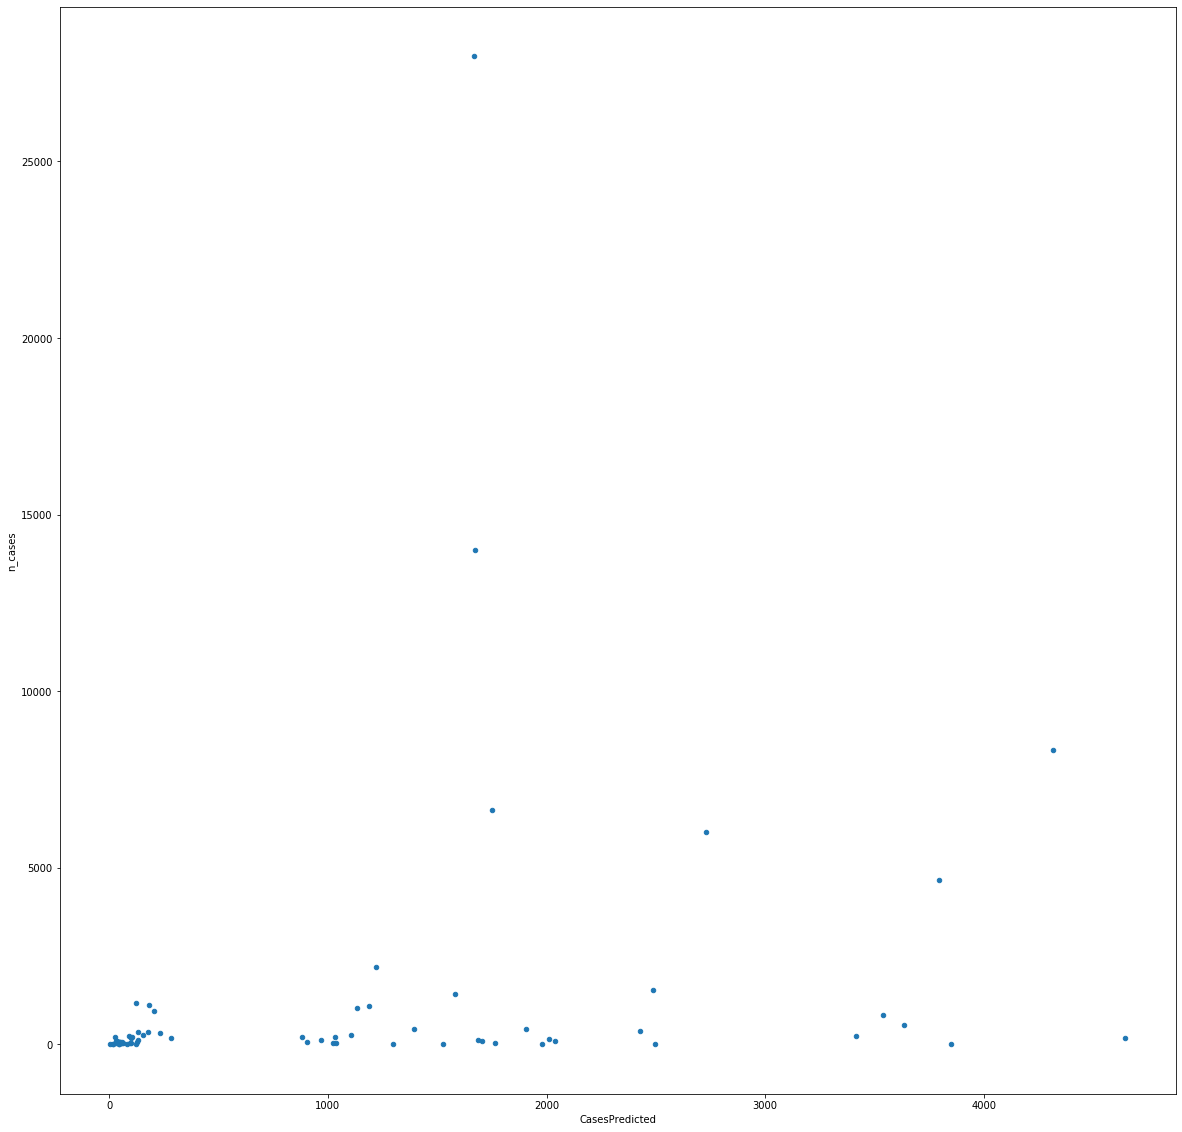

In [777]:
df_results.drop('China').plot.scatter(x='CasesPredicted', y='n_cases')

In [778]:
#state_df_final.join(daily_cases).drop('China').corr(method='kendall')

In [779]:
#correlation_pivot = correlation_df.pivot(index='P', columns='R', values='Euclidean Distance')
#correlation_pivot

In [780]:
#heatmap = sns.heatmap(correlation_pivot.iloc[:,5:6], annot=True)